In [1]:
import pandas as pd
import matplotlib as plt
import matplotlib.pyplot as plt
import numpy as np
from sqlalchemy import create_engine
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [2]:
# Replace the following variables with your PostgreSQL credentials
DB_USER = 'postgres'
DB_PASSWORD = 'password'
DB_HOST = 'localhost'
DB_PORT = '5432'
DB_NAME = 'AdventureWorks'

# Create the PostgreSQL connection string
connection_string = f'postgresql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}'

# Create the SQLAlchemy engine
engine = create_engine(connection_string)

with open("COMPOSITE_TABLE1_bikedailysales.sql", "r") as query_file:
    query = query_file.read()

df_bike = pd.read_sql(query, con=engine, index_col = 'orderdate', parse_dates = 'orderdate').asfreq("D") #df of date and total value of orders of bikes

with open("COMPOSITE_TABLE1_componentdailysales_reduced.sql", "r") as query_file:
    query = query_file.read()

df_component = pd.read_sql(query, con=engine, index_col = 'orderdate', parse_dates = 'orderdate').asfreq("D") #df of date and total value of orders of components

# Remember to close the SQLAlchemy engine after you finish using it
engine.dispose()

In [3]:
model_bike = ExponentialSmoothing(endog=df_bike.totalorders, trend="add", seasonal="mul", seasonal_periods=30).fit() #model for bike
predictions_bike = model_bike.forecast(steps = 180)

C:\Users\jacob\anaconda3\envs\IODF_env\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Text(0.5, 1.0, 'Bike: Order quantity vs date')

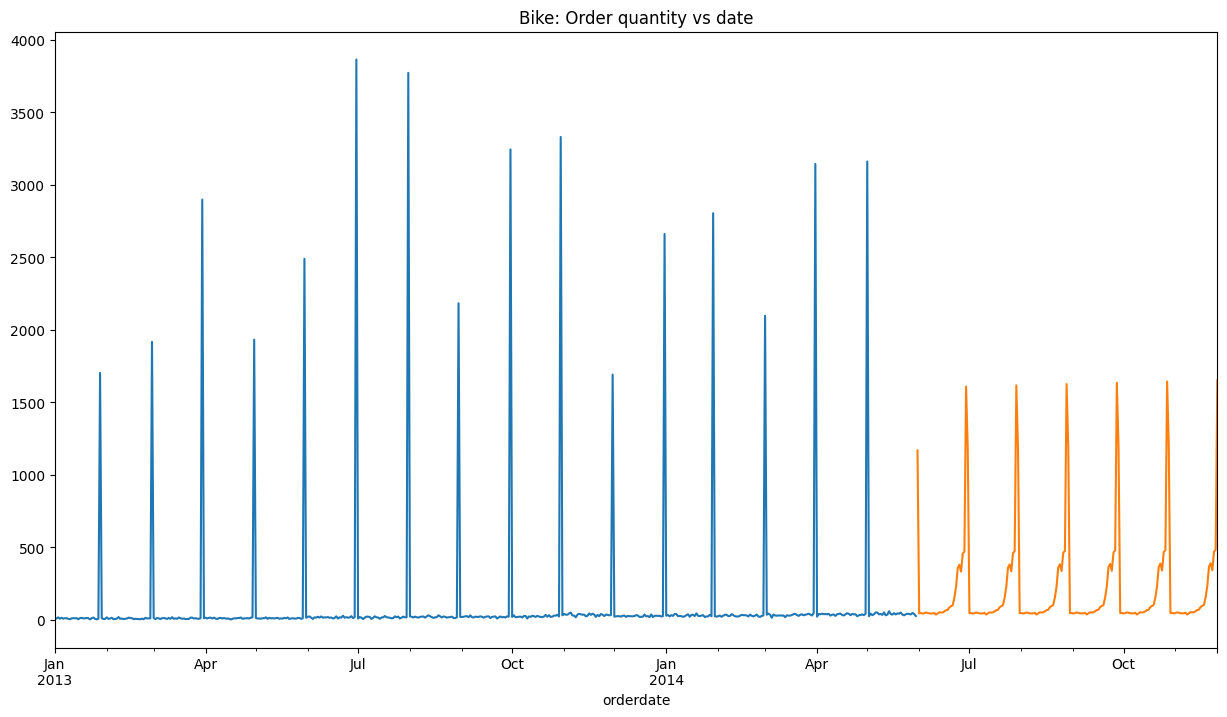

In [4]:
df_bike['totalorders']['2013-01-01':].plot(figsize=(15,8))
predictions_bike.plot()
plt.title('Bike: Order quantity vs date')

In [5]:
model_component = ExponentialSmoothing(endog=df_component.totalorders, trend="add", seasonal="add", seasonal_periods=31).fit() #model for component
predictions_component = model_component.forecast(steps = 180)

Text(0.5, 1.0, 'Component: Order quantity vs date')

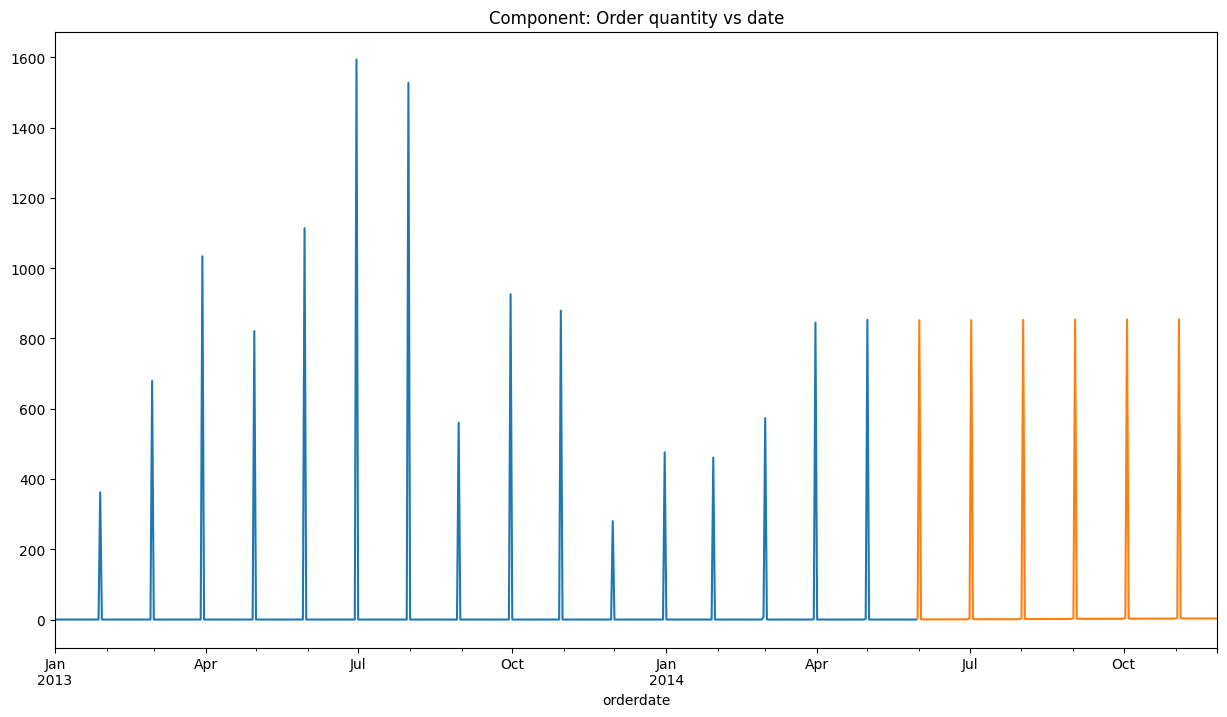

In [6]:
df_component['totalorders']['2013-01-01':].plot(figsize=(15,8))
predictions_component.plot()
plt.title('Component: Order quantity vs date')

In [7]:
## Random Forest for bike

window_size = 14 # set window size
 
    
# Creating lag features (columns that represent the past observations within the chosen window size)
for i in range(1, window_size + 1):
    df_bike[f'Sales_Lag_{i}'] = df_bike['totalorders'].shift(i)


# Creating binary columns named "2nd_last," "last," "first," and "2nd" based on the position of each observation within its respective month    
    
# Create a binary column "2nd_last" (1 if it's the 2nd to last day of the month, else 0)
df_bike['2nd_last'] = (df_bike.index.day == (df_bike.index.days_in_month - 1)).astype(int)

# Create a binary column "last" (1 if it's the last day of the month, else 0)
df_bike['last'] = (df_bike.index.day == df_bike.index.days_in_month).astype(int)

# Create a binary column "first" (1 if it's the first day of the month, else 0)
df_bike['first'] = (df_bike.index.day == 1).astype(int)

# Create a binary column "2nd" (1 if it's the 2nd day of the month, else 0)
df_bike['2nd'] = (df_bike.index.day == 2).astype(int) 


# Remove rows with NA values

df_bike = df_bike.dropna()

In [8]:
# Organize Data into Input Features (X) and Target Variable (y)
X = df_bike.drop(columns=['totalorders'])  # Drop the target variable
y = df_bike['totalorders']  # Target variable

# Define the split point (e.g., 80% for training, 20% for testing)
split_point = int(0.8 * len(X))

# Split the data into training and testing sets
X_train, X_test = X.iloc[:split_point], X.iloc[split_point:]
y_train, y_test = y.iloc[:split_point], y.iloc[split_point:]

In [9]:
# Train a Supervised Learning Model

from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [10]:
# RF model evaluation

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

y_pred = rf_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')

Mean Absolute Error: 19.946543778801843
Mean Squared Error: 8800.802603686636
Root Mean Squared Error: 93.8125929909553


In [11]:
# Assuming X_test contains the features for your future predictions
# Replace X_test with your actual feature data
future_predictions = rf_model.predict(X_test)

# Create a date range for your future predictions (adjust as needed)
date_range = pd.date_range(start='2014-05-31', periods=len(future_predictions), freq='D')

# Create a DataFrame for your predictions
predictions_df = pd.DataFrame({'Date': date_range, 'Predicted_Orders': future_predictions})

# Set the 'Date' column as the index
predictions_df.set_index('Date', inplace=True)

In [12]:
from scipy.stats import norm

# Assuming X_test contains the features for your future predictions
# Replace X_test with your actual feature data
future_predictions = rf_model.predict(X_test)

# Calculate prediction errors (residuals)
prediction_errors = y_test - future_predictions

# Define confidence level (e.g., 90%)
confidence_level = 0.90

# Calculate critical values for the prediction interval
alpha = 1 - confidence_level
z_lower = norm.ppf(alpha / 2)
z_upper = norm.ppf(1 - alpha / 2)

# Calculate standard deviations for 'totalorders' greater than 500 and less than 500
std_dev_gt_500 = prediction_errors[y_test > 500].std()
std_dev_lt_500 = prediction_errors[y_test < 500].std()

# Apply the appropriate standard deviation based on the condition
std_dev_condition = np.where(y_test > 500, std_dev_gt_500, std_dev_lt_500)

# Calculate the prediction interval for each prediction
lower_bounds = future_predictions - z_upper * std_dev_condition
upper_bounds = future_predictions + z_upper * std_dev_condition

# Ensure that lower_bounds is never less than 0
lower_bounds = np.maximum(lower_bounds, 0)

# Create a date range for your future predictions (adjust as needed)
date_range = pd.date_range(start='2014-05-31', periods=len(future_predictions), freq='D')

# Create a DataFrame for your predictions and prediction intervals
predictions_df = pd.DataFrame({'Date': date_range, 'Predicted_Orders': future_predictions, 'Lower_Bound': lower_bounds, 'Upper_Bound': upper_bounds})

# Set the 'Date' column as the index
predictions_df.set_index('Date', inplace=True)

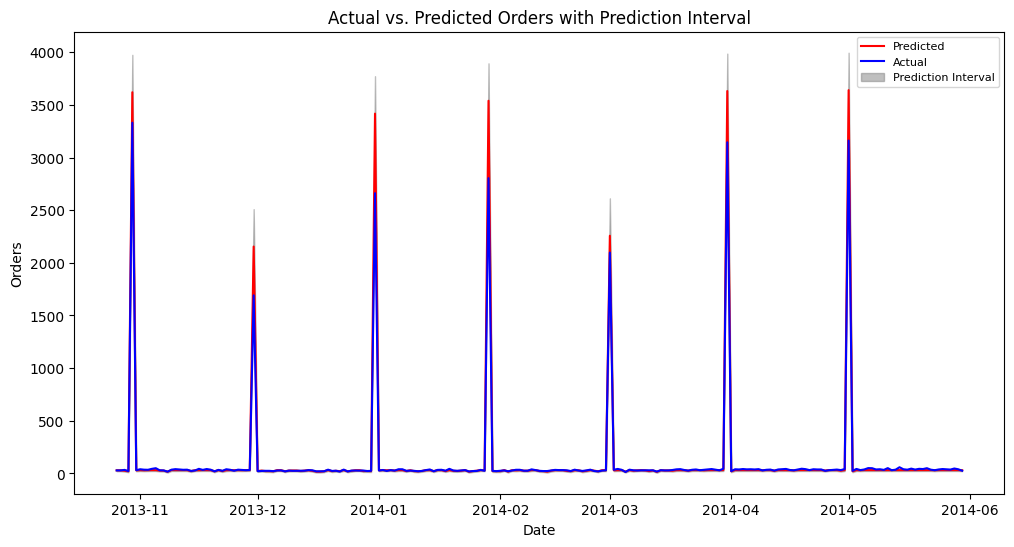

In [13]:
# Create a figure and axis
plt.figure(figsize=(12, 6))

# Plot predicted values (y_pred) in red
plt.plot(y_test.index, y_pred, label='Predicted', color='red')

# Plot actual values (y_test) in blue
plt.plot(y_test.index, y_test, label='Actual', color='blue')

# Plot the lower and upper bounds as shaded regions
plt.fill_between(y_test.index, lower_bounds, upper_bounds, color='gray', alpha=0.5, label='Prediction Interval')

# Set labels and title
plt.xlabel('Date')
plt.ylabel('Orders')
plt.title('Actual vs. Predicted Orders with Prediction Interval')

# Add a legend
plt.legend(fontsize=8)

# Show the plot
plt.show()

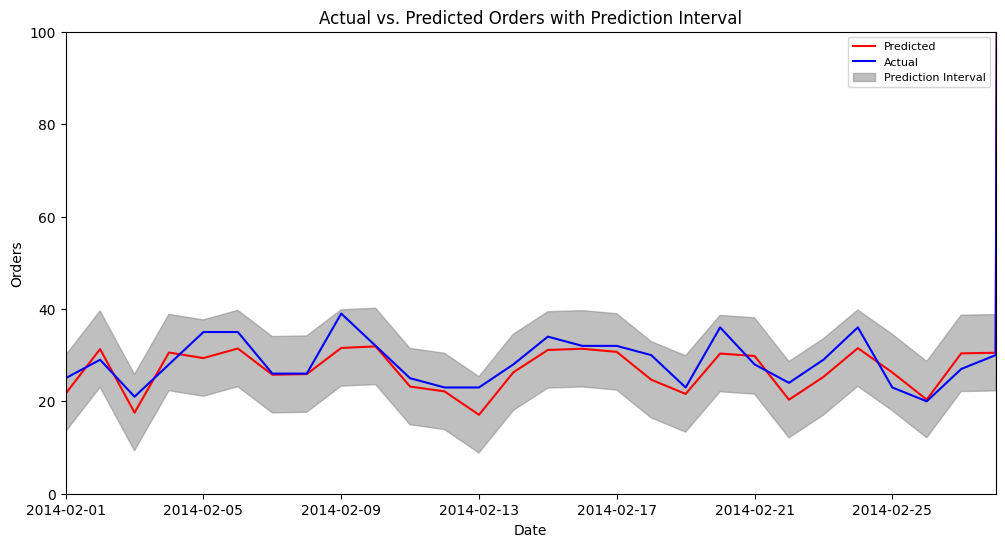

In [14]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming y_test.index contains the date values
# Define the start and end date for the specific period you want to cover
start_date = pd.to_datetime('2014-02-01')
end_date = pd.to_datetime('2014-02-28')  # Replace with your desired end date

# Create a figure and axis
plt.figure(figsize=(12, 6))

# Plot predicted values (y_pred) in red
plt.plot(y_test.index, y_pred, label='Predicted', color='red')

# Plot actual values (y_test) in blue
plt.plot(y_test.index, y_test, label='Actual', color='blue')

# Plot the lower and upper bounds as shaded regions
plt.fill_between(y_test.index, lower_bounds, upper_bounds, color='gray', alpha=0.5, label='Prediction Interval')

# Set labels and title
plt.xlabel('Date')
plt.ylabel('Orders')
plt.title('Actual vs. Predicted Orders with Prediction Interval')

# Add a legend
plt.legend(fontsize=8)

# Set the x-axis limits to the specific period you want to cover
plt.xlim(start_date, end_date)

# Set the y-axis limits to 0-100
plt.ylim(0, 100)

# Show the plot
plt.show()

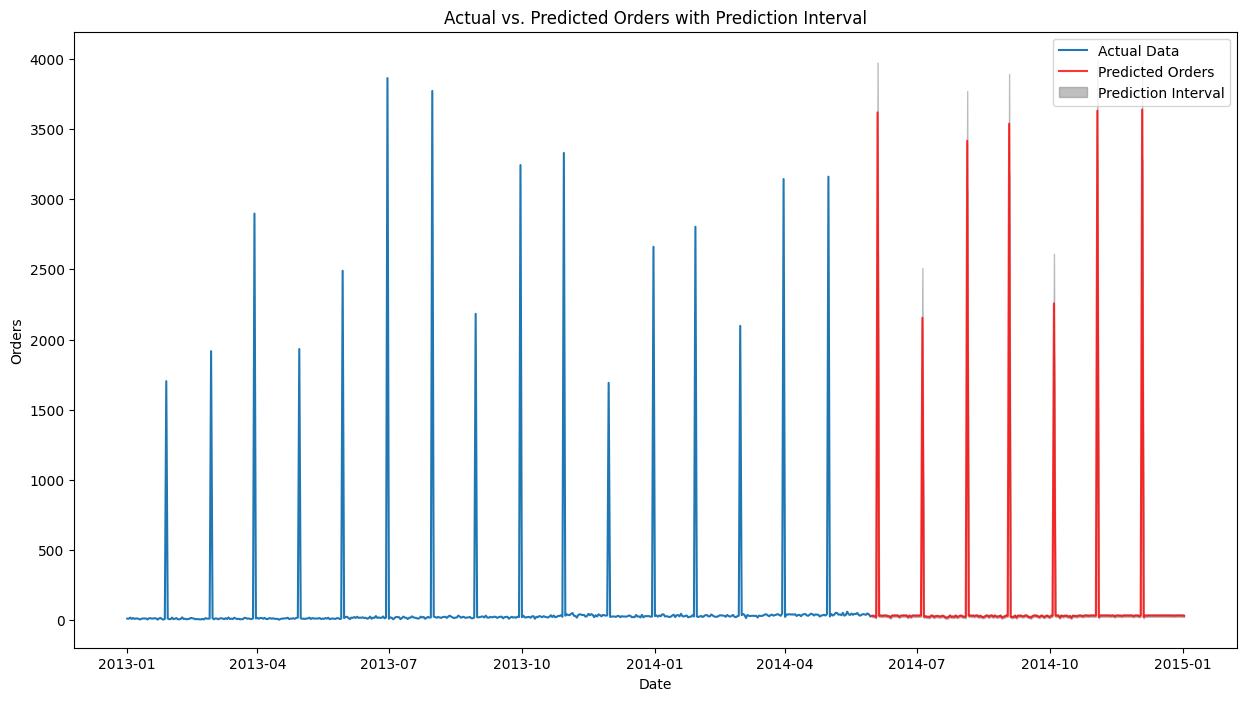

In [15]:
plt.figure(figsize=(15, 8))

# Plot the actual data
plt.plot(df_bike['totalorders']['2013-01-01':], label='Actual Data')

# Plot the predicted orders in red
plt.plot(predictions_df['Predicted_Orders'], label='Predicted Orders', color='red', alpha = .8)

# Plot the lower and upper bounds as shaded regions
plt.fill_between(predictions_df.index, predictions_df['Lower_Bound'], predictions_df['Upper_Bound'], color='gray', alpha=0.5, label='Prediction Interval')

# Add a legend
plt.legend()

# Set the title and labels
plt.title('Actual vs. Predicted Orders with Prediction Interval')
plt.xlabel('Date')
plt.ylabel('Orders')

# Show the plot
plt.show()

In [16]:
## Random Forest for component

window_size = 18 # set window size
 
    
# Creating lag features (columns that represent the past observations within the chosen window size)
for i in range(1, window_size + 1):
    df_component[f'Sales_Lag_{i}'] = df_component['totalorders'].shift(i)


# Creating binary columns named "2nd_last," "last," "first," and "2nd" based on the position of each observation within its respective month    
    
# Create a binary column "2nd_last" (1 if it's the 2nd to last day of the month, else 0)
df_component['2nd_last'] = (df_component.index.day == (df_component.index.days_in_month - 1)).astype(int)

# Create a binary column "last" (1 if it's the last day of the month, else 0)
df_component['last'] = (df_component.index.day == df_component.index.days_in_month).astype(int)

# Create a binary column "first" (1 if it's the first day of the month, else 0)
df_component['first'] = (df_component.index.day == 1).astype(int)

# Create a binary column "2nd" (1 if it's the 2nd day of the month, else 0)
df_component['2nd'] = (df_component.index.day == 2).astype(int) 


# Remove rows with NA values
df_component = df_component.dropna()

In [17]:
# Organize Data into Input Features (X) and Target Variable (y)
X = df_component.drop(columns=['totalorders'])  # Drop the target variable
y = df_component['totalorders']  # Target variable

# Define the split point (e.g., 80% for training, 20% for testing)
split_point = int(0.8 * len(X))

# Split the data into training and testing sets
X_train, X_test = X.iloc[:split_point], X.iloc[split_point:]
y_train, y_test = y.iloc[:split_point], y.iloc[split_point:]

In [18]:
# Train a Supervised Learning Model

from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [19]:
# RF model evaluation

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

y_pred = rf_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')

Mean Absolute Error: 1.5881481481481483
Mean Squared Error: 108.62637037037038
Root Mean Squared Error: 10.422397534654413


In [20]:
# Assuming X_test contains the features for your future predictions
# Replace X_test with your actual feature data
future_predictions = rf_model.predict(X_test)

# Create a date range for your future predictions (adjust as needed)
date_range = pd.date_range(start='2014-05-31', periods=len(future_predictions), freq='D')

# Create a DataFrame for your predictions
predictions_df = pd.DataFrame({'Date': date_range, 'Predicted_Orders': future_predictions})

# Set the 'Date' column as the index
predictions_df.set_index('Date', inplace=True)

In [21]:
from scipy.stats import norm

# Assuming X_test contains the features for your future predictions
# Replace X_test with your actual feature data
future_predictions = rf_model.predict(X_test)

# Calculate prediction errors (residuals)
prediction_errors = y_test - future_predictions

# Define confidence level (e.g., 90%)
confidence_level = .90

# Calculate critical values for the prediction interval
alpha = 1 - confidence_level
z_lower = norm.ppf(alpha / 2)
z_upper = norm.ppf(1 - alpha / 2)

# Calculate standard deviations for 'totalorders' greater than 500 and less than 500
std_dev_gt_100 = prediction_errors[y_test > 100].std()
std_dev_lt_100 = prediction_errors[y_test < 100].std()

# Apply the appropriate standard deviation based on the condition
std_dev_condition = np.where(y_test > 100, std_dev_gt_100, std_dev_lt_100)

# Calculate the prediction interval for each prediction
lower_bounds = future_predictions - z_upper * std_dev_condition
upper_bounds = future_predictions + z_upper * std_dev_condition

# Ensure that lower_bounds is never less than 0
lower_bounds = np.maximum(lower_bounds, 0)

# Create a date range for your future predictions (adjust as needed)
date_range = pd.date_range(start='2014-05-31', periods=len(future_predictions), freq='D')

# Create a DataFrame for your predictions and prediction intervals
predictions_df = pd.DataFrame({'Date': date_range, 'Predicted_Orders': future_predictions, 'Lower_Bound': lower_bounds, 'Upper_Bound': upper_bounds})

# Set the 'Date' column as the index
predictions_df.set_index('Date', inplace=True)

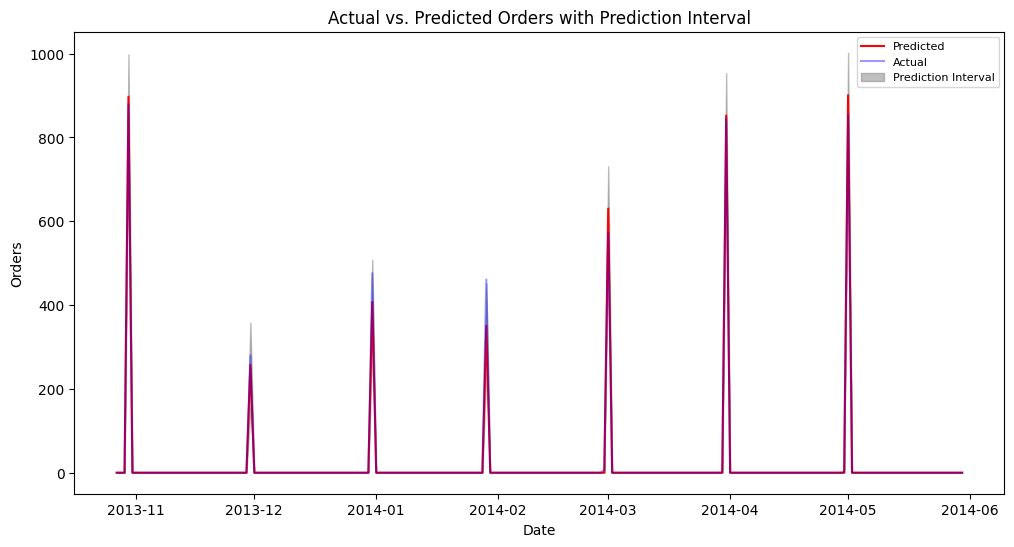

In [22]:
# Create a figure and axis
plt.figure(figsize=(12, 6))

# Plot predicted values (y_pred) in red
plt.plot(y_test.index, y_pred, label='Predicted', color='red')

# Plot actual values (y_test) in blue
plt.plot(y_test.index, y_test, label='Actual', color='blue', alpha=0.4)

# Plot the lower and upper bounds as shaded regions
plt.fill_between(y_test.index, lower_bounds, upper_bounds, color='gray', alpha=0.5, label='Prediction Interval')

# Set labels and title
plt.xlabel('Date')
plt.ylabel('Orders')
plt.title('Actual vs. Predicted Orders with Prediction Interval')

# Add a legend
plt.legend(fontsize=8)

# Show the plot
plt.show()

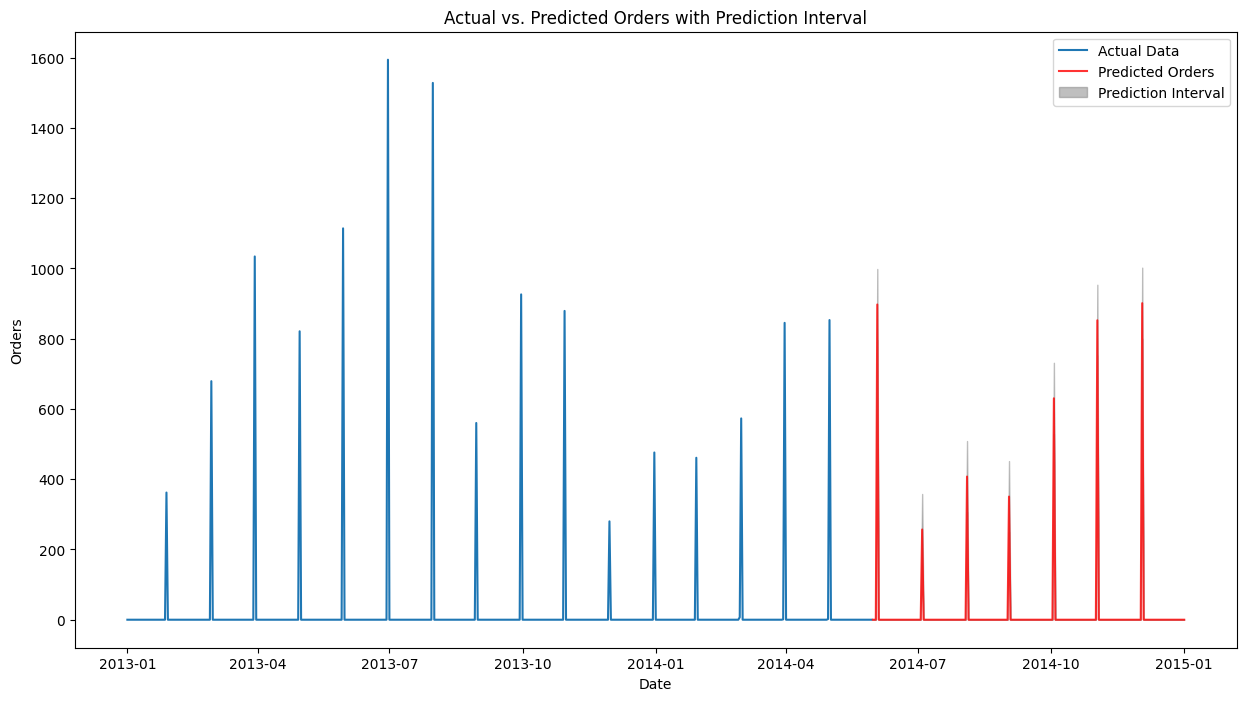

In [23]:
plt.figure(figsize=(15, 8))

# Plot the actual data
plt.plot(df_component['totalorders']['2013-01-01':], label='Actual Data')

# Plot the predicted orders in red
plt.plot(predictions_df['Predicted_Orders'], label='Predicted Orders', color='red', alpha = .8)

# Plot the lower and upper bounds as shaded regions
plt.fill_between(predictions_df.index, predictions_df['Lower_Bound'], predictions_df['Upper_Bound'], color='gray', alpha=0.5, label='Prediction Interval')

# Add a legend
plt.legend()

# Set the title and labels
plt.title('Actual vs. Predicted Orders with Prediction Interval')
plt.xlabel('Date')
plt.ylabel('Orders')

# Show the plot
plt.show()

In [24]:
## Import lead time data for different products and create data frame

import psycopg2
import pandas as pd

# Replace the following variables with your PostgreSQL credentials
DB_USER = 'postgres'
DB_PASSWORD = 'password'
DB_HOST = 'localhost'
DB_PORT = '5432'
DB_NAME = 'AdventureWorks'

# Create a PostgreSQL connection
connection = psycopg2.connect(
    user=DB_USER, password=DB_PASSWORD, host=DB_HOST, port=DB_PORT, database=DB_NAME
)

# Read the SQL query from the "leadtime_calculations.sql" file
with open("leadtime_calculations.sql", "r") as sql_file:
    sql_query = sql_file.read()

# Use psycopg2 to execute the SQL query
cursor = connection.cursor()
cursor.execute(sql_query)

# Create a Pandas DataFrame from the query result
df = pd.DataFrame(cursor.fetchall(), columns=[desc[0] for desc in cursor.description])

# Close the cursor and connection
cursor.close()
connection.close()

# Convert lead time values to integers
for column in df.columns:
    if pd.api.types.is_timedelta64_dtype(df[column]):
        # Replace NaT values with Timedelta of 0 days
        df[column] = df[column].fillna(pd.Timedelta(days=0))
        # Convert timedelta to integer (representing days)
        df[column] = df[column].dt.days.astype(int)

In [25]:
## Calculating the average and std lead time of all bikes

subcategories = ['Road Bikes', 'Touring Bikes', 'Mountain Bikes']
avg_lead_time = df[df['subcategory_adj'].isin(subcategories)]['rounded_avg_manufacture_time'].mean()

# Calculating the root sum squared lead time of all bikes

std_devs = df[df['subcategory_adj'].isin(subcategories)]['rounded_stddev_manufacture_time']

# Step 1: Square each standard deviation
squared_std_devs = std_devs**2

# Step 2: Sum the squared standard deviations
sum_of_squares = squared_std_devs.sum()

# Step 3: Take the square root to get the RSS
rss_std_dev = np.sqrt(sum_of_squares)

In [26]:
import scipy.stats as stats
import math

# Safety Stock and reorder point calculcations

# Filter bike df to capture days without spikes

filtered_df = df_bike[df_bike['totalorders'] < 500]

# Input values
avg_lead_time = df[df['subcategory_adj'].isin(subcategories)]['rounded_avg_manufacture_time'].mean()  # Average lead time in days
std_demand = filtered_df['totalorders'].std() # Standard deviation of demand
avg_demand = filtered_df['totalorders'].mean() # Average daily demand
std_lead_time = rss_std_dev # Standard deviation of lead time
service_level = 0.95  # Desired service level (e.g., 95%)

# Calculate Z-score based on the desired service level
z_score = stats.norm.ppf(service_level)

# Calculate the safety stock using the formula
safety_stock = z_score * math.sqrt((avg_lead_time * std_demand**2) + (avg_demand * std_lead_time**2))
safety_stock = math.ceil(safety_stock)

# Print the calculated safety stock
print(f"Calculated Safety Stock During Standard Demand: {safety_stock}") # Calculate the safety stock using the formula

Calculated Safety Stock During Standard Demand: 97


In [27]:
# Reorder point calculation for all bikes

# Input values (replace these with your data)
avg_demand = filtered_df['totalorders'].mean()  # Average daily demand
avg_lead_time = df[df['subcategory_adj'].isin(subcategories)]['rounded_avg_manufacture_time'].mean()  # Average lead time in days
std_lead_time = rss_std_dev # Standard deviation of lead time
demand_variance = filtered_df['totalorders'].var()  # Variability in demand (in units per day)

# Calculate the reorder point
demand_during_lead_time = avg_demand * avg_lead_time
safety_stock = z_score * math.sqrt((std_lead_time**2 * demand_variance))
reorder_point = demand_during_lead_time + safety_stock

# Round up the reorder point to the nearest integer
reorder_point = math.ceil(reorder_point)

# Display the reorder point
print(f"Reorder Point: {reorder_point}")

Reorder Point: 413
